In [1]:
%reload_ext autoreload
%autoreload 2  

# Load data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

file_name = "IrishNationalTideGaugeNetwork_8eaa_cdad_02f5.csv"
file_name_big = "IrishNationalTideGaugeNetwork_070c_f250_eaf8.csv"
file_name_big_big = "IrishNationalTideGaugeNetwork_8335_68d5_7ab9.csv"

file_name = file_name_big_big


df = pd.read_csv(file_name)
df.drop(columns=['latitude', 'longitude', 'Water_Level_OD_Malin'], inplace=True)
df = df.iloc[1:]
df['Water_Level_LAT'] = df['Water_Level_LAT'].astype(float)
mean_every_12_rows = df.groupby(df.index // 12)['Water_Level_LAT'].mean()[700:1500]

mean_every_12_rows

700     1.933333
701     2.335083
702     2.686333
703     2.960500
704     3.058000
          ...   
1495    2.817083
1496    3.269333
1497    3.485083
1498    3.353417
1499    2.878000
Name: Water_Level_LAT, Length: 800, dtype: float64

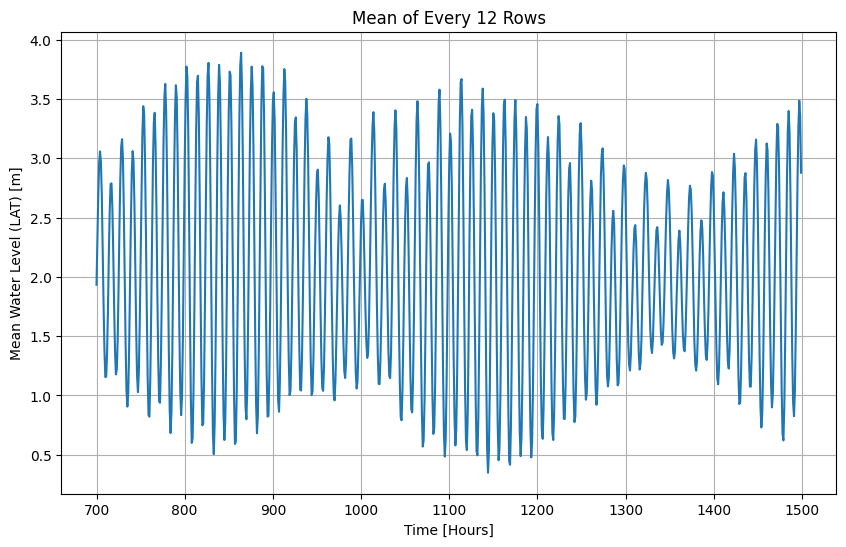

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(mean_every_12_rows.index, mean_every_12_rows.values)
plt.title('Mean of Every 12 Rows')
plt.xlabel('Time [Hours]')
plt.ylabel('Mean Water Level (LAT) [m]')
plt.grid(True)
plt.show()

# Expectation matrix

### Format data

In [4]:
import numpy as np
data = np.array(mean_every_12_rows)
print(data.shape)
print(data[0])

# Rescale the data to be between 0 and 2np.pi
data = (data - data.min())/(data.max() - data.min()) * 2 * np.pi
data[150]

# get training data
train_x = data[:-30]
print(train_x.shape)

# # get test data
# test_x = data[-30:]
# print(test_x.shape)

(800,)
1.9333333333333333
(770,)


In [5]:
m = 9

n = (m-1)*5

train_matrix = np.tile(data, (n, 1)).transpose()
print("train_matrix.shape: ", train_matrix.shape)
train_matrix[:2] 

# # prediction matrix
# test_matrix = np.tile(test_x, (n, 1)).transpose()
# print("test_matrix.shape: ", test_matrix.shape)

train_matrix.shape:  (800, 40)


array([[2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776,
        2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776,
        2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776,
        2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776,
        2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776,
        2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776,
        2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776,
        2.81256776, 2.81256776, 2.81256776, 2.81256776, 2.81256776],
       [3.52531951, 3.52531951, 3.52531951, 3.52531951, 3.52531951,
        3.52531951, 3.52531951, 3.52531951, 3.52531951, 3.52531951,
        3.52531951, 3.52531951, 3.52531951, 3.52531951, 3.52531951,
        3.52531951, 3.52531951, 3.52531951, 3.52531951, 3.52531951,
        3.52531951, 3.52531951, 3.52531951, 3.52531951, 3.52531951,
        3.52531951, 3.52531951, 3.52531951, 3.52531951, 3.52531951,
        3.52531951, 3.52531951, 3.52531951, 3.5

### Generate circuit object

In [6]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_train = train_matrix.shape[0]
memory_length = 7

simulator = lrs.PhotonicReservoirSimulator(m, t_max_train, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 800/800 [00:02<00:00, 377.32it/s]


In [7]:
import pickle

input_state = pcvl.BasicState([1]*(m-1) + [0]*1)
# input_state = pcvl.BasicState([0, 1, 0, 1, 0, 1, 0, 1])
# train_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
#                                                                         input_state, memory_length=memory_length)
full_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
                                                                        input_state,
                                                                        memory_length=200)

print("expectations_matrix.shape = ", np.array(full_expectation_matrix).shape)

pickle.dump(full_expectation_matrix, open(f"full_expectation_matrix_{len(full_expectation_matrix)}_memory{memory_length}.pkl", "wb"))

Processing time steps:   0%|          | 0/800 [00:00<?, ?it/s]

Processing time steps: 100%|██████████| 800/800 [02:25<00:00,  5.50it/s]

expectations_matrix.shape =  (800, 9)


In [8]:
import pickle
# Open the full_expectation_matrix
full_expectation_matrix = pickle.load(open(f"full_expectation_matrix_800_memory7.pkl", "rb"))
input_state = pcvl.BasicState([1]*(m-1) + [0]*1)

full_expectation_matrix = full_expectation_matrix[:800]
new_data = data[:800]

### Split data

In [9]:
# Train Test split
split_int = 400 # 50

test_expectation_matrix = full_expectation_matrix[-split_int:]
train_expectation_matrix = full_expectation_matrix[:-split_int]
print("train_expectation_matrix.shape = ", np.array(train_expectation_matrix).shape)
print("test_expectation_matrix.shape = ", np.array(test_expectation_matrix).shape)


test_x = new_data[-split_int:]
train_x = new_data[:-split_int]

print("train_x.shape = ", np.array(train_x).shape)
print("test_x.shape = ", np.array(test_x).shape)

train_expectation_matrix.shape =  (400, 9)
test_expectation_matrix.shape =  (400, 9)
train_x.shape =  (400,)
test_x.shape =  (400,)


# Quadratic Regression

In [10]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Assuming 'train_expectation_matrix' and 'train_x' are defined and available

# Pop the last row of expectations_matrix
expectations_matrix_red = np.array(train_expectation_matrix)[:-1]
print("expectations_matrix.shape = ", expectations_matrix_red.shape)

# Make prediction vector
labels = np.array(train_x)[1:]
data_red = np.array(train_x)[:]
print("labels:", labels[:3])
print("data_red: ", data_red[:4])
print("labels shape: ", labels.shape)

# Transform the data to include quadratic terms
poly = PolynomialFeatures(degree=12)
expectations_matrix_quad = poly.fit_transform(expectations_matrix_red)

# Fit the quadratic model with Ridge regularization
# You can adjust the alpha parameter to control the strength of the regularization
reg_ridge = Ridge(alpha=0.5).fit(expectations_matrix_quad, labels)

# 'reg_ridge' is now a Ridge regression model fit to the quadratic terms


expectations_matrix.shape =  (399, 9)
labels: [3.52531951 4.14847831 4.63488222]
data_red:  [2.81256776 3.52531951 4.14847831 4.63488222]
labels shape:  (399,)


#### Predict test data

predicted_data.shape =  (400,)


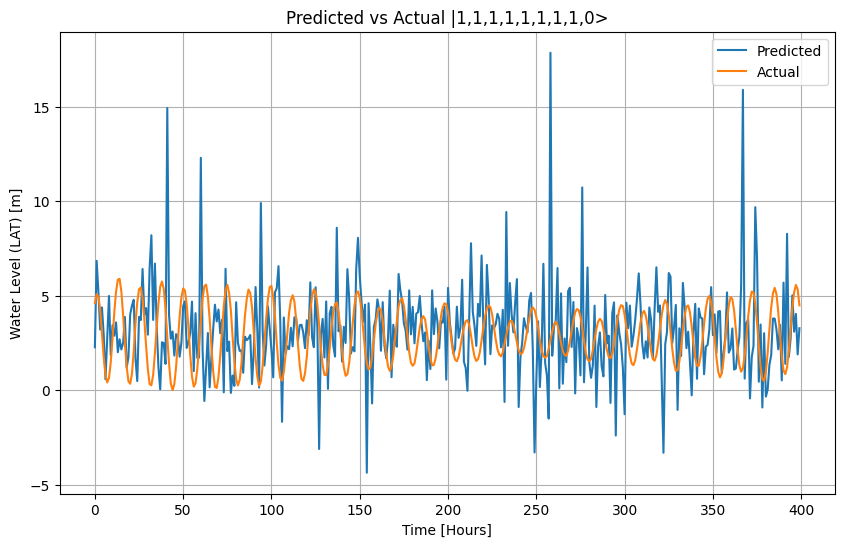

In [11]:
test_expectation_matrix_quad = poly.fit_transform(test_expectation_matrix)

# Make predictions using the quadratic model
predicted_test_data_quad = reg_ridge.predict(test_expectation_matrix_quad)
print("predicted_data.shape = ", predicted_test_data_quad.shape)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predicted_test_data_quad, label=f'Predicted')
plt.plot(test_x, label='Actual')
plt.title(f'Predicted vs Actual {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)

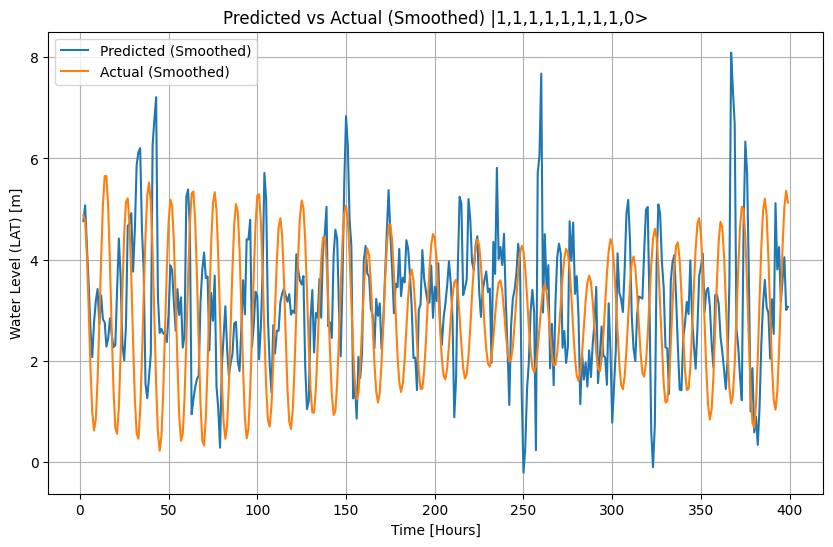

In [12]:
# Convert arrays to pandas Series for easy manipulation
predicted_series = pd.Series(predicted_test_data_quad)
actual_series = pd.Series(test_x)

# Apply a moving average (rolling mean). You can adjust the window size as needed.
window_size = 3  # This is the number of data points used for calculating the average
predicted_smoothed = predicted_series.rolling(window=window_size).mean()
actual_smoothed = actual_series.rolling(window=window_size).mean()

# Plotting the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(predicted_smoothed[:], label='Predicted (Smoothed)')
plt.plot(actual_smoothed[:], label='Actual (Smoothed)')
plt.title(f'Predicted vs Actual (Smoothed) {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)
plt.show()

#### Predict train data

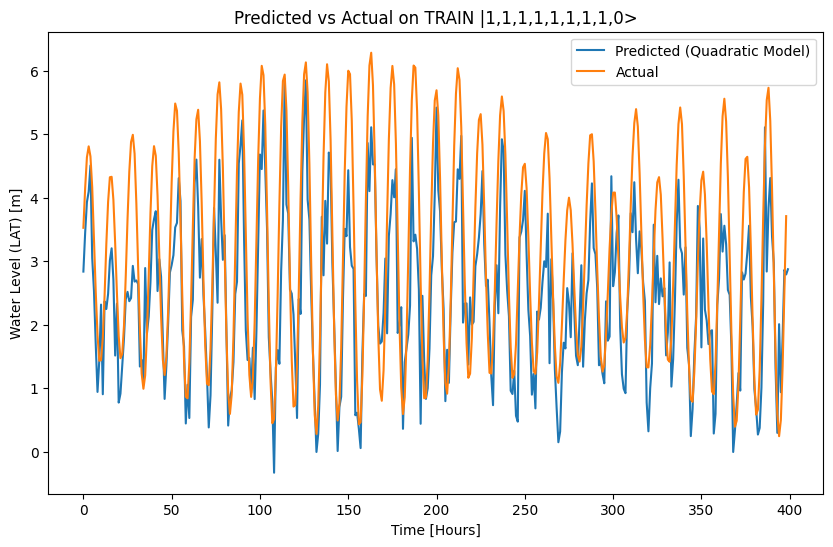

In [13]:
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming 'reg_quad' is your trained quadratic model and 'train_expectation_matrix' is available

# Transform the training data to include quadratic terms
train_expectation_matrix_quad = poly.fit_transform(train_expectation_matrix)

# Make predictions using the quadratic model
predicted_train_data_quad = reg_ridge.predict(train_expectation_matrix_quad) - 0.7


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(predicted_train_data_quad[:], label='Predicted (Quadratic Model)')
plt.plot(new_data[1:-split_int], label='Actual')
plt.title(f'Predicted vs Actual on TRAIN {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.show()


# Plot full data

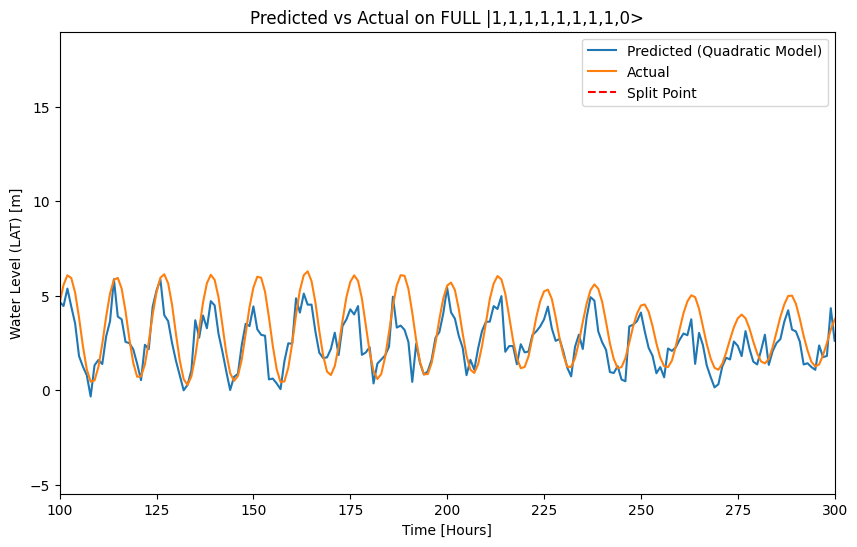

In [14]:
# append predicted train quad and test quad
FULL_data_quad = np.append(predicted_train_data_quad, predicted_test_data_quad)[:]



# Plotting
plt.figure(figsize=(10, 6))
plt.plot(FULL_data_quad, label='Predicted (Quadratic Model)')
plt.plot(new_data[:], label='Actual')
plt.axvline(x=len(FULL_data_quad)-split_int, color='r', linestyle='--', label='Split Point')
plt.title(f'Predicted vs Actual on FULL {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')

# Set the x-axis limits to zoom in
x_min = 100  # Replace with your desired minimum x-value
x_max = 300 # Replace with your desired maximum x-value
plt.xlim(x_min, x_max)

plt.legend()
plt.show()


# Neural network

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

### Define NN

In [16]:
class SimpleNetwork(nn.Module):
    def __init__(self, input_size):
        self.input_size = input_size
        super(SimpleNetwork, self).__init__()
        self.layer1 = nn.Linear(in_features=self.input_size, out_features=200)
        self.layer2 = nn.Linear(in_features=200, out_features=200)
        self.layer3 = nn.Linear(in_features=200, out_features=100)
        self.layer4 = nn.Linear(in_features=100, out_features=1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x.squeeze()  # This will change shape from [batch_size, 1] to [batch_size]


net = SimpleNetwork(input_size=m)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


### Train NN

In [17]:
# Train Test split
split_int = 600 # 50

test_expectation_matrix = full_expectation_matrix[-split_int:]
train_expectation_matrix = full_expectation_matrix[:-split_int]
print("train_expectation_matrix.shape = ", np.array(train_expectation_matrix).shape)
print("test_expectation_matrix.shape = ", np.array(test_expectation_matrix).shape)


test_x = new_data[-split_int:]
train_x = new_data[:-split_int]

print("train_x.shape = ", np.array(train_x).shape)
print("test_x.shape = ", np.array(test_x).shape)

train_expectation_matrix.shape =  (200, 9)
test_expectation_matrix.shape =  (600, 9)
train_x.shape =  (200,)
test_x.shape =  (600,)


/var/folders/1c/lzf0rt2544qcxpwv506msskh0000gn/T/ipykernel_54056/1542565727.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_expectation_matrix = torch.tensor(train_expectation_matrix).float()
/var/folders/1c/lzf0rt2544qcxpwv506msskh0000gn/T/ipykernel_54056/1542565727.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(train_x).float()


train_expectation_matrix.shape =  torch.Size([200, 9])
train_x.shape =  torch.Size([200])
Epoch 1/100, Loss: 0.2889
Epoch 2/100, Loss: 0.2249
Epoch 3/100, Loss: 0.3050
Epoch 4/100, Loss: 0.2272
Epoch 5/100, Loss: 0.3821
Epoch 6/100, Loss: 0.3987
Epoch 7/100, Loss: 0.3155
Epoch 8/100, Loss: 0.3413
Epoch 9/100, Loss: 0.1929
Epoch 10/100, Loss: 0.1455
Epoch 11/100, Loss: 0.1358
Epoch 12/100, Loss: 0.1321
Epoch 13/100, Loss: 0.1383
Epoch 14/100, Loss: 0.1233
Epoch 15/100, Loss: 0.1934
Epoch 16/100, Loss: 0.2072
Epoch 17/100, Loss: 0.1724
Epoch 18/100, Loss: 0.1283
Epoch 19/100, Loss: 0.1664
Epoch 20/100, Loss: 0.2072
Epoch 21/100, Loss: 0.2203
Epoch 22/100, Loss: 0.2029
Epoch 23/100, Loss: 0.1647
Epoch 24/100, Loss: 0.1467
Epoch 25/100, Loss: 0.1543
Epoch 26/100, Loss: 0.1177
Epoch 27/100, Loss: 0.0847
Epoch 28/100, Loss: 0.0823
Epoch 29/100, Loss: 0.0857
Epoch 30/100, Loss: 0.0789
Epoch 31/100, Loss: 0.1046
Epoch 32/100, Loss: 0.1104
Epoch 33/100, Loss: 0.1056
Epoch 34/100, Loss: 0.0891
E

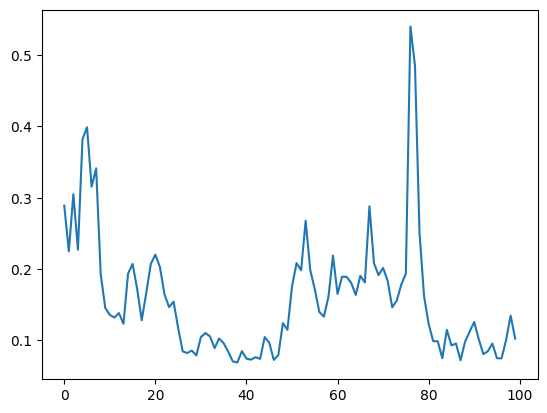

In [30]:
train_expectation_matrix = torch.tensor(train_expectation_matrix).float()
train_x = torch.tensor(train_x).float()
print("train_expectation_matrix.shape = ", train_expectation_matrix.shape)
print("train_x.shape = ", train_x.shape)
dataset = TensorDataset(train_expectation_matrix, train_x)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Training function
def train(model, dataloader, optimizer, epochs):
    model.train()  # Set the model to training mode
    loss_list = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = F.mse_loss(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_loss)
        tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    plt.plot(loss_list)

# Train the network
train(net, dataloader, optimizer, epochs=100)

NameError: name 'loss_list' is not defined

### Predict with NN

In [19]:
# Inference function
def predict(model, inputs):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        outputs = model(inputs)
    return outputs

# Example inference
prediction = prediction = predict(net, torch.tensor(test_expectation_matrix).float())

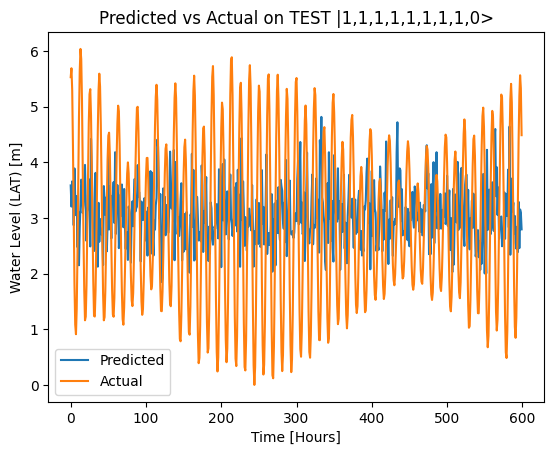

In [32]:
plt.plot(prediction, label='Predicted')
plt.plot(test_x, label='Actual')
plt.title(f'Predicted vs Actual on TEST {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()